In [31]:
import sys
import os
import time
import datetime
import matplotlib.pyplot as plt
sys.path.append(".")
sys.path.append("..")

from algorithms.old_path_planning import OldPathPlanner
from algorithms.path_planning import PathPlanner, stanley_smooth_path
from algorithms.optimized_path_planning import stanley_smooth_path as optimized_smooth_path
from algorithms.david_planning import torch_smooth, PathPlanner as DavidPathPlanning, stanley_smooth_path as david_smooth
from algorithms.pathplanning_morepoints_lessbloat import PathPlanner as MorePointsPlanning

from tvojemama.logger import LogReader

import torch
from torch import optim

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Gather data from log

In [32]:
# Gets the latest log
log_dir = "../data/bros_logs"
logs = os.listdir(log_dir)
log_path = [datetime.datetime.strptime(log, "%d_%m_%Y-%H_%M_%S") for log in logs]
latest_log = logs[log_path.index(max(log_path, key = lambda x: x.timestamp()))]
last_log_dir = os.path.join(log_dir, latest_log,"AS")
last_mission_log = list(filter(lambda x: x.startswith("mission"), os.listdir(last_log_dir)))
log_reader = LogReader(os.path.join(last_log_dir, last_mission_log[0]))

61970.753875712 61970.787691705


In [33]:
period = 0.01 # time between percep_data samples in seconds

percep_datas = []

counter = 0
start_time = None
for msg_t, (msg_name, data) in log_reader:
    
    mission_kwargs = data['mission_kwargs']
    percep_data = mission_kwargs['percep_data']
    
    if start_time is None:
        start_time = msg_t
        
    curr_msg_t = msg_t - start_time
        
    if curr_msg_t / period >= counter:
        counter += 1
        
        if percep_data.shape[0] != 0:
            percep_datas.append(percep_data)
    
print(f"got {len(percep_datas)} samples")

got 258 samples


## Run tests

In [34]:
def benchmark_path_planning(find_path_fn, smooth_fn=None):
    indiv_times = []
    start_time = time.time()
    for percep_data in percep_datas:
        curr_start_time = time.time()
        path = find_path_fn(percep_data)
        
        if smooth_fn is not None:
            path = smooth_fn(path)
            
        curr_end_time = time.time()
        indiv_times.append(curr_end_time - curr_start_time)
    end_time = time.time()
    
    print(f"took {end_time - start_time:.2f} seconds")
    print(f"\tMean time: {((end_time - start_time) / len(percep_datas) * 1000):.3f} ms")
    print(f"\tMax time: {max(indiv_times) * 1000:.3f} ms")
    print(f"\tMin time: {min(indiv_times) * 1000:.3f} ms")

In [35]:
# initializing
path_planner = PathPlanner()
old_path_planner = OldPathPlanner({"n_steps": 20})
david_planner = DavidPathPlanning()
more_points_planner = MorePointsPlanning()

In [36]:
benchmark_path_planning(find_path_fn=path_planner.find_path, smooth_fn=stanley_smooth_path)

took 2.65 seconds
	Mean time: 10.268 ms
	Max time: 28.460 ms
	Min time: 3.073 ms


In [37]:
benchmark_path_planning(find_path_fn=path_planner.find_path, smooth_fn=None)

took 1.10 seconds
	Mean time: 4.279 ms
	Max time: 13.536 ms
	Min time: 0.660 ms


In [38]:
benchmark_path_planning(find_path_fn=old_path_planner.find_path, smooth_fn=None)

took 0.20 seconds
	Mean time: 0.759 ms
	Max time: 5.143 ms
	Min time: 0.140 ms


In [39]:
benchmark_path_planning(find_path_fn=old_path_planner.find_path, smooth_fn=optimized_smooth_path)

took 1.47 seconds
	Mean time: 5.690 ms
	Max time: 50.452 ms
	Min time: 1.921 ms


In [40]:
benchmark_path_planning(find_path_fn=david_planner.find_path, smooth_fn=david_smooth)

took 1.50 seconds
	Mean time: 5.827 ms
	Max time: 11.924 ms
	Min time: 2.645 ms


In [41]:
benchmark_path_planning(find_path_fn=david_planner.find_path, smooth_fn=None)

took 0.22 seconds
	Mean time: 0.850 ms
	Max time: 2.805 ms
	Min time: 0.278 ms


In [42]:
benchmark_path_planning(find_path_fn=more_points_planner.find_path, smooth_fn=None)

took 1.10 seconds
	Mean time: 4.282 ms
	Max time: 14.516 ms
	Min time: 0.625 ms


## Custom solution

In [43]:
# squggle indices
## 231
## 219, 218, 217, 216, 215, 214, 213, 212, 211, 210, 209, 208

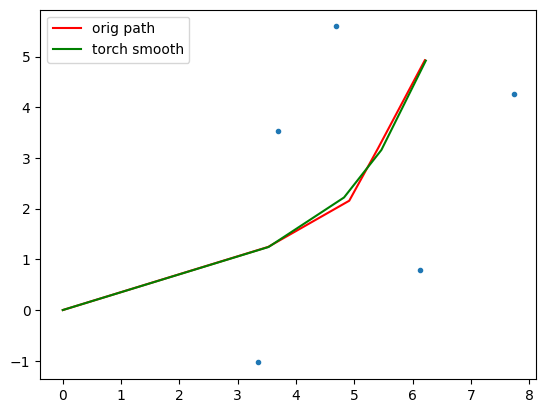

In [45]:
cones = percep_datas[215]
path = david_planner.find_path(cones)
smoother_path = torch_smooth(path)
# smoother_path = david_smooth(path)
stanley_smoother_path = stanley_smooth_path(path)


plt.plot(cones[:,0], cones[:,1], '.')
plt.plot(path[:,0], path[:,1], '-', color='red' ,label='orig path')
plt.plot(smoother_path[:,0], smoother_path[:,1], '-', color='green', label='torch smooth')
# plt.plot(stanley_smoother_path[:,0], stanley_smoother_path[:,1], '-', color='orange', label='stanley smooth')
plt.legend()
plt.show()

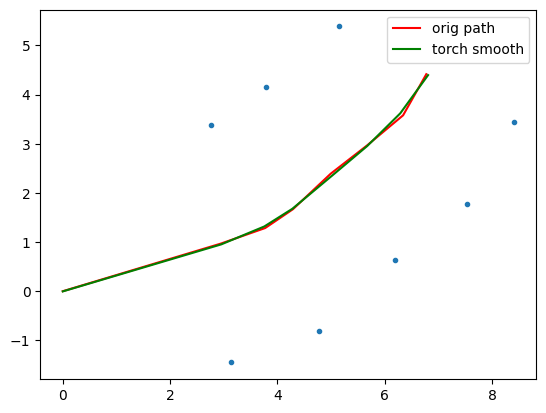

In [ ]:
plt.plot(cones[:,0], cones[:,1], '.')
plt.plot(path[:,0], path[:,1], '-', color='red' ,label='orig path')
plt.plot(smoother_path[:,0], smoother_path[:,1], '-', color='green', label='torch smooth')
plt.legend()
plt.show()

In [ ]:
benchmark_path_planning(find_path_fn=david_planner.find_path, smooth_fn=torch_smooth)

took 1.17 seconds
	Mean time: 4.369 ms
	Max time: 10.090 ms
	Min time: 2.937 ms


In [ ]:
def benchmark_path_planning_torch(find_path_fn, smooth_fn=None):
    path_records = []
    indiv_times = []
    start_time = time.time()
    for percep_data in percep_datas:
        curr_start_time = time.time()
        path = find_path_fn(percep_data)
        
        if smooth_fn is not None:
            path, loss = smooth_fn(path)
            path_records.append((path, loss))
            
        curr_end_time = time.time()
        indiv_times.append(curr_end_time - curr_start_time)
    end_time = time.time()
    
    print(f"took {end_time - start_time:.2f} seconds")
    print(f"\tMean time: {((end_time - start_time) / len(percep_datas) * 1000):.3f} ms")
    print(f"\tMax time: {max(indiv_times) * 1000:.3f} ms")
    print(f"\tMin time: {min(indiv_times) * 1000:.3f} ms")
    
    return path_records

In [ ]:
path_records = benchmark_path_planning_torch(find_path_fn=david_planner.find_path, smooth_fn=torch_smooth)

took 2.43 seconds
	Mean time: 9.055 ms
	Max time: 31.126 ms
	Min time: 7.565 ms


In [ ]:
path_records

[(array([[ 0.        , -0.02038669],
         [ 4.4366527 , -0.41305014],
         [ 5.7679844 , -0.35833588],
         [ 6.853016  , -0.28981295],
         [ 8.43711   , -0.274712  ],
         [10.006656  , -0.34183598],
         [11.682921  , -0.40833125],
         [13.0320835 , -0.42936638],
         [14.149179  , -0.4317814 ]], dtype=float32),
  -111.72688293457031),
 (array([[ 0.        , -0.02038669],
         [ 4.4366527 , -0.41305014],
         [ 5.7679844 , -0.35833588],
         [ 6.853016  , -0.28981295],
         [ 8.43711   , -0.274712  ],
         [10.006656  , -0.34183598],
         [11.682921  , -0.40833125],
         [13.0320835 , -0.42936638],
         [14.149179  , -0.4317814 ]], dtype=float32),
  -111.72688293457031),
 (array([[ 0.        , -0.02039554],
         [ 4.435174  , -0.41279674],
         [ 5.766501  , -0.35803503],
         [ 6.8515296 , -0.28946358],
         [ 8.435624  , -0.2742865 ],
         [10.005172  , -0.34133714],
         [11.68144   , -0.4077

In [ ]:
path_records = sorted(path_records, key=lambda x: x[1], reverse=True)

In [ ]:
path_records

[(array([[ 0.       ,  0.       ],
         [ 1.3767066, -0.8598507]], dtype=float32),
  0.0),
 (array([[ 0.       ,  0.       ],
         [ 1.2297038, -0.8943157]], dtype=float32),
  0.0),
 (array([[ 0.        , -0.03837134],
         [ 3.9269414 ,  1.9143114 ],
         [ 5.3074355 ,  3.220869  ]], dtype=float32),
  -15.057784080505371),
 (array([[ 0.        , -0.03927007],
         [ 3.6623468 ,  1.7120097 ],
         [ 5.092115  ,  2.964922  ]], dtype=float32),
  -15.185003280639648),
 (array([[ 0.        , -0.03420948],
         [ 3.821394  ,  2.0599284 ],
         [ 5.3845716 ,  3.6214647 ]], dtype=float32),
  -15.192038536071777),
 (array([[ 0.        , -0.03994169],
         [ 3.5404878 ,  1.5936273 ],
         [ 5.0005507 ,  2.8112702 ]], dtype=float32),
  -15.240616798400879),
 (array([[ 0.        , -0.03466675],
         [ 3.700744  ,  1.9056256 ],
         [ 5.3126154 ,  3.4172997 ]], dtype=float32),
  -15.25931167602539),
 (array([[ 0.        , -0.04070691],
         [ 3.4

In [ ]:
filter_path_records = [(p, c) for p, c in path_records if p.shape[0] > 5]

In [ ]:
filter_path_records

[(array([[ 0.        , -0.11214344],
         [ 2.4127266 ,  0.9743743 ],
         [ 3.3835204 ,  2.3446844 ],
         [ 3.9938335 ,  3.8426654 ],
         [ 4.5251646 ,  5.0513525 ],
         [ 5.0968976 ,  6.189169  ]], dtype=float32),
  -60.743446350097656),
 (array([[ 0.        , -0.11554451],
         [ 2.3003886 ,  0.93612117],
         [ 3.2869275 ,  2.2936044 ],
         [ 3.9183683 ,  3.7823687 ],
         [ 4.465677  ,  4.9839406 ],
         [ 5.051974  ,  6.1143174 ]], dtype=float32),
  -60.899208068847656),
 (array([[ 0.        , -0.11554451],
         [ 2.3003886 ,  0.93612117],
         [ 3.2869275 ,  2.2936044 ],
         [ 3.9183683 ,  3.7823687 ],
         [ 4.465677  ,  4.9839406 ],
         [ 5.051974  ,  6.1143174 ]], dtype=float32),
  -60.899208068847656),
 (array([[ 0.        , -0.07128529],
         [ 3.207498  ,  0.70233583],
         [ 3.9386594 ,  1.2144417 ],
         [ 4.7610745 ,  2.426894  ],
         [ 5.0855603 ,  3.2864563 ],
         [ 5.4670377 ,  4.

cost =  -61.79322052001953
cost =  -62.19719314575195
cost =  -62.4794807434082
cost =  -62.68291473388672
cost =  -62.83251190185547


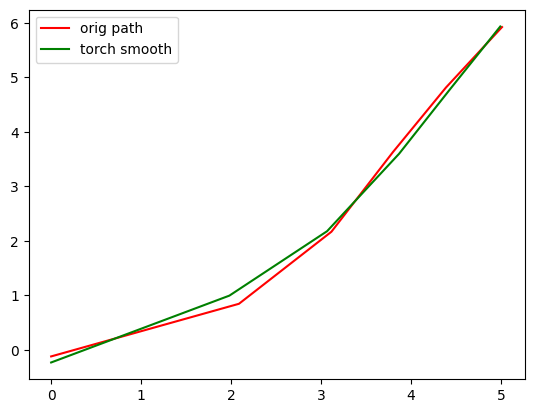

In [ ]:
path, c = filter_path_records[5]
# path = david_planner.find_path(cones)
smoother_path, _ = torch_smooth(path)

# plt.plot(cones[:,0], cones[:,1], '.')
plt.plot(path[:,0], path[:,1], '-', color='red' ,label='orig path')
plt.plot(smoother_path[:,0], smoother_path[:,1], '-', color='green', label='torch smooth')
plt.legend()
plt.show()